# Stochastic Simulations Assignment 3: Reverse Engineering Predator-Prey System

#### Job Marcelis, 14000946

#### Ernani Hazbolatow, 14272210

#### Haitham Muhidin, 13970356

Below are the required `Python` packages to run the code.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

plt.rcParams['figure.dpi'] = 300

To get a better understanding of the Lotka Volterra equations, we solve them using the following parameters: $\alpha = 3$, $\beta = 2$, $\delta = -1$, $\gamma = -2$. Furthermore, we use `solve_ivp` to solve the system of equations deterministically.

In [29]:
def LV_eqs(t, var, params):
    x, y = var
    a, b, c, d = params

    dxdt = a*x - b*x*y
    dydt = - c*y + d*x*y

    return [dxdt, dydt]

def solve_LV(start_time, stop_time, steps, initial_conditions, params):
    time_span = np.linspace(start_time, stop_time, steps)
    result = solve_ivp(LV_eqs, [start_time, stop_time], initial_conditions, args=(params,), t_eval=time_span, method='RK45')
    X = result.y[0, :]
    Y = result.y[1, :]
    t = result.t

    return X, Y, t

In [31]:
init_cond = [4, 2]
params = [3, 2, 1, 2]
X, Y, t = solve_LV(0, 20, 1000, init_cond, params)

In addition to showing the time evolution of the deterministic model, we can also plot the phase space for multiple initial conditions. This reveals the periodic behaviour.

In [57]:
pred_pop = [1, 3, 5, 7]
phase_plot_X = np.zeros((len(pred_pop), 1000))
phase_plot_Y = np.zeros((len(pred_pop), 1000))

for i, pop in enumerate(pred_pop):
    X_phase, Y_phase, _ = solve_LV(10, 20, 1000, [4, pop], params)
    phase_plot_X[i, :] = X_phase
    phase_plot_Y[i, :] = Y_phase

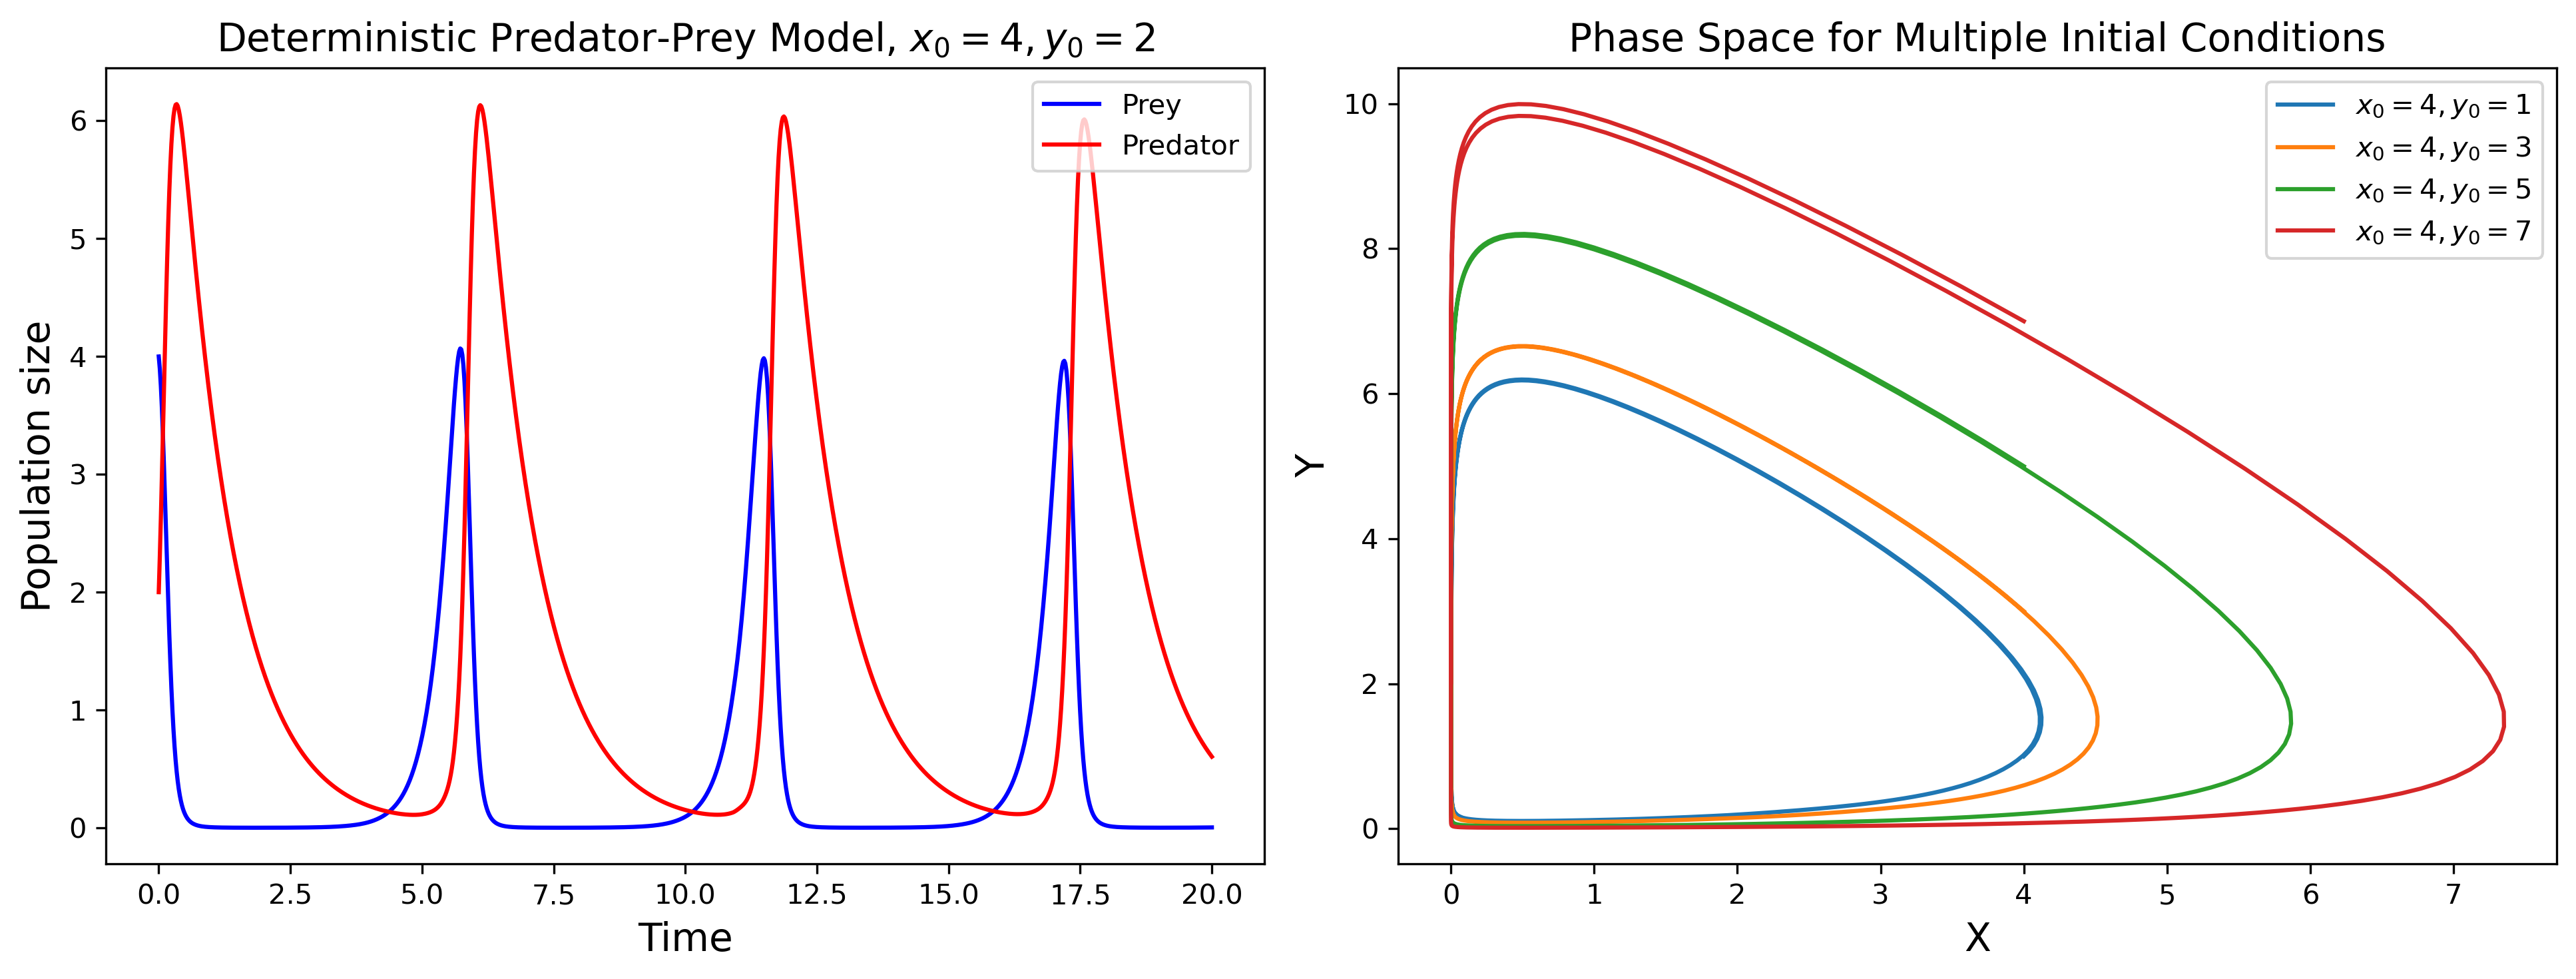

In [58]:
colors = ['#87CEEB', '#ADD8E6', '#00BFFF', '#1E90FF']
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.title(fr'Deterministic Predator-Prey Model, $x_0 = {{{init_cond[0]}}}, y_0 = {{{init_cond[1]}}}$', fontsize=14)
plt.plot(t, X, color='blue', label='Prey')
plt.plot(t, Y, color='red', label='Predator')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title('Phase Space for Multiple Initial Conditions', fontsize=14)
for i in range(len(pred_pop)):
    plt.plot(phase_plot_X[i, :], phase_plot_Y[i, :], label=fr'$x_0 = {{{init_cond[0]}}}, y_0 = {{{pred_pop[i]}}}$')
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

Now, we plot the data that was given in `predator-prey-data.csv`.

In [5]:
data = pd.read_csv('predator-prey-data.csv')
t_data = data['t']
X_data = data['x']
Y_data = data['y']

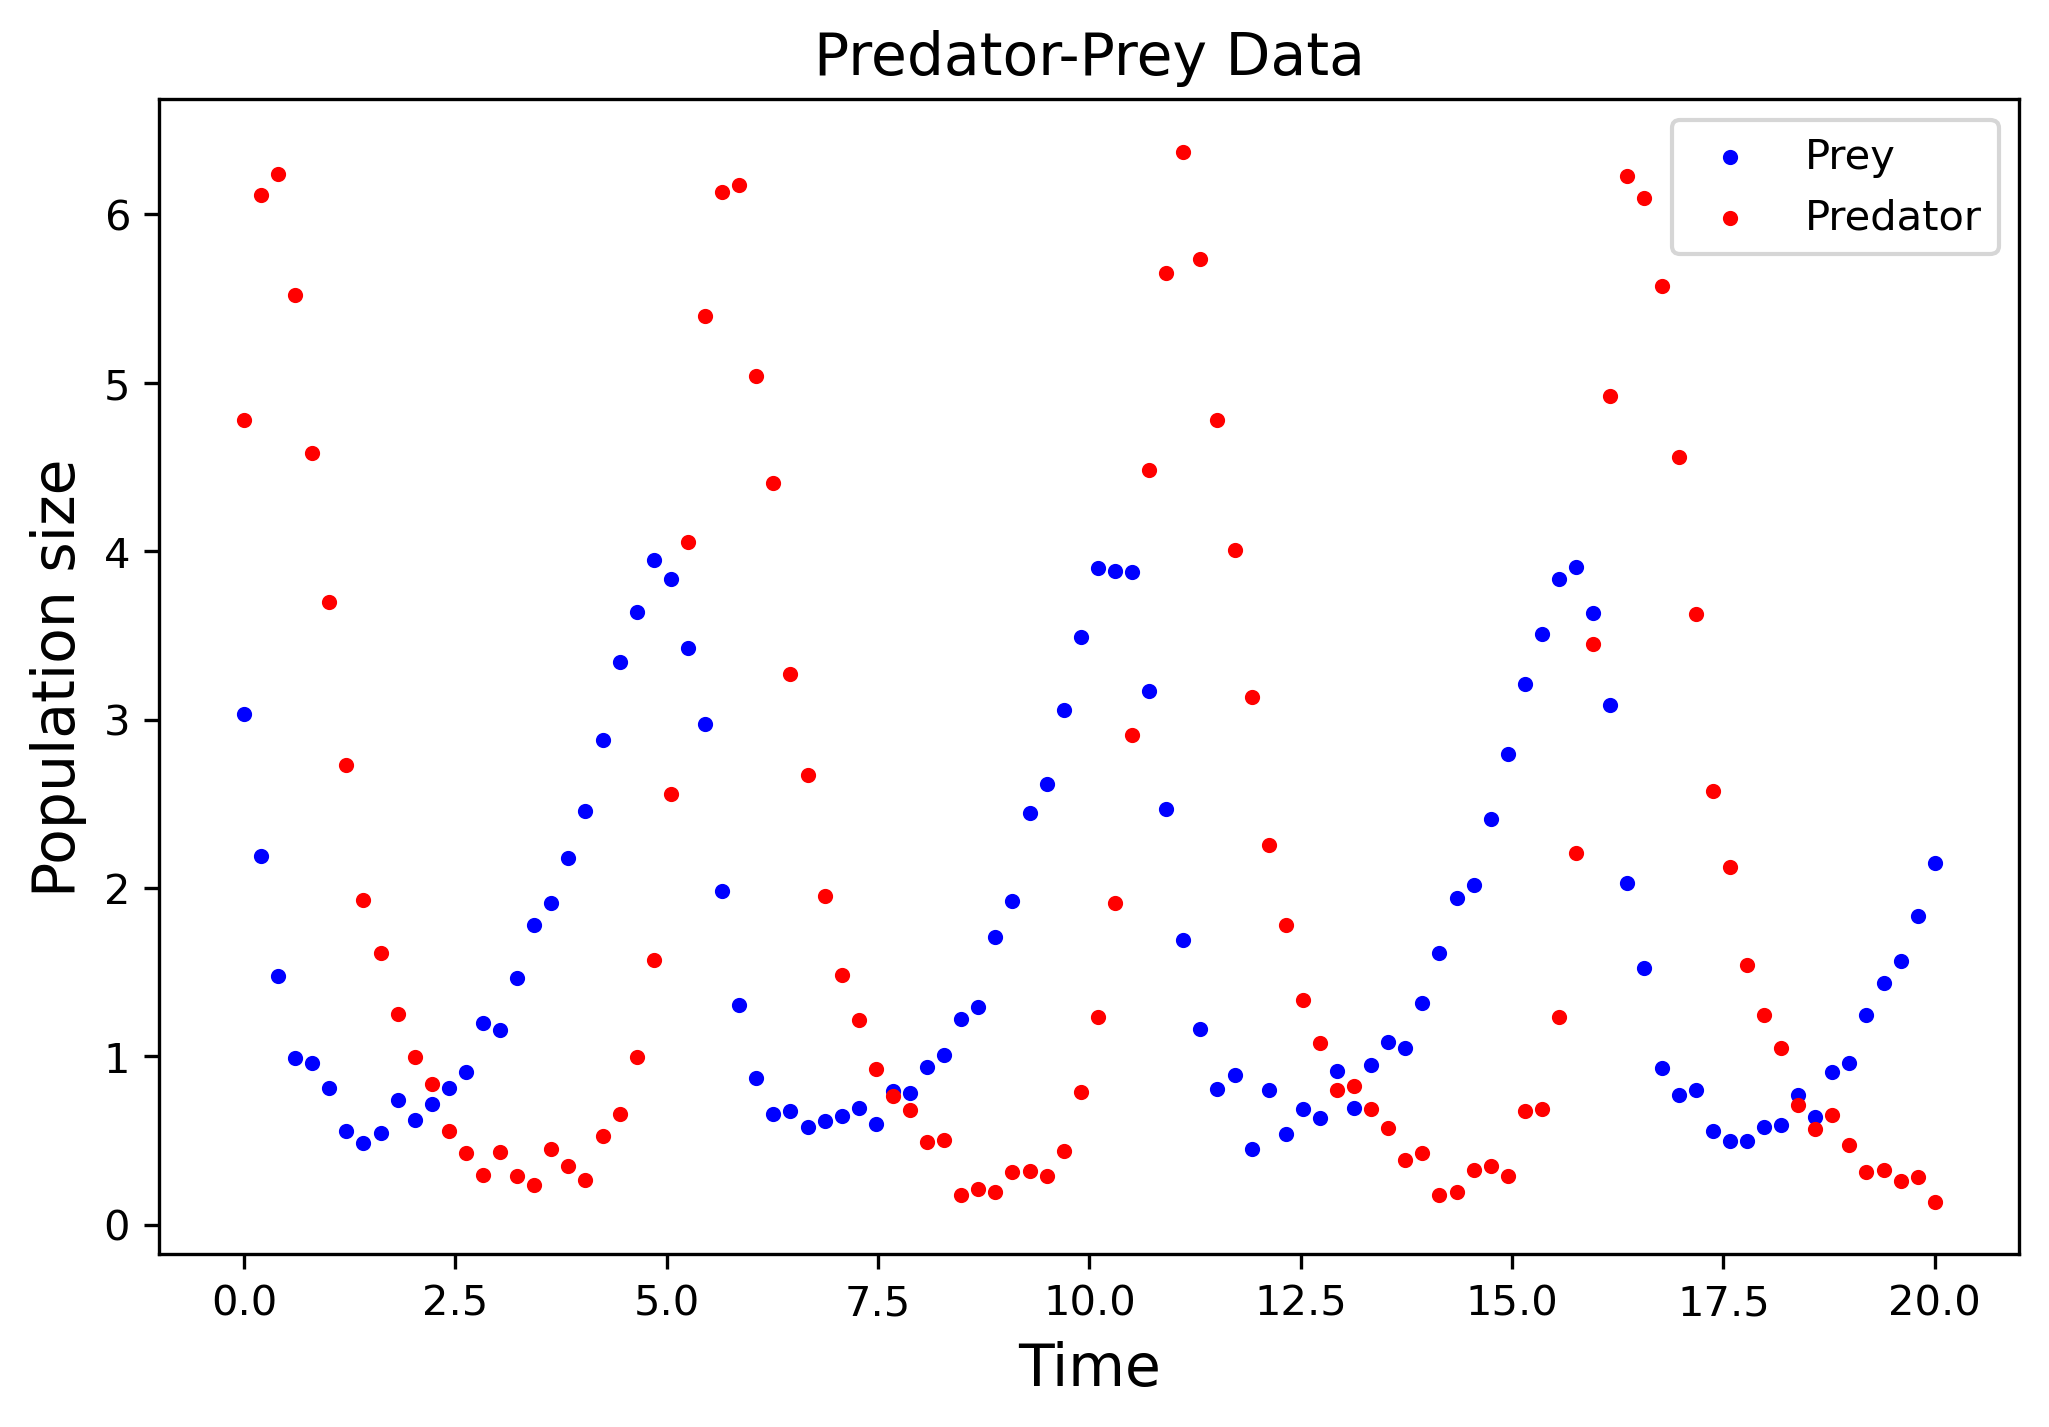

In [53]:
plt.figure(figsize=(8, 5))
plt.title('Predator-Prey Data', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend()
plt.show()

The goal is to find the best parameters to describe the data, which is done with two different optimizing algorithms, Hill climbing and Simulated Annealing.